# Demonstrate MLPs on Images

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
def create_cross_pattern():
    """
    Creates a 3x3 cross pattern.
    """
    pattern = np.zeros((3, 3))
    pattern[1, :] = 1  # Horizontal line
    pattern[:, 1] = 1  # Vertical line
    return pattern

def create_box_pattern():
    """
    Creates a 3x3 cross pattern.
    """
    pattern = np.zeros((3, 3))
    pattern[1, 3] = 1  # Horizontal line
    pattern[:, 1] = 1  # Vertical line
    return pattern


In [3]:
def place_pattern_on_image(position, pattern, image_size=(8, 8)):
    """
    Places the pattern on an image at the specified position.
    """
    image = np.zeros(image_size)
    x, y = position
    pattern_size = pattern.shape[0]
    image[x:x+pattern_size, y:y+pattern_size] = pattern
    return image


In [4]:
def generate_dataset(cross_positions, num_negative_samples=100):
    """
    Generates a dataset with the cross at specified positions and random negatives.
    """
    images = []
    labels = []
    pattern = create_cross_pattern()

    # Positive samples
    for pos in cross_positions:
        image = place_pattern_on_image(pos, pattern)
        images.append(image.flatten())
        labels.append(1)

    # Negative samples (random noise)
    for _ in range(num_negative_samples):
        image = np.random.randint(0, 2, size=(8, 8))
        images.append(image.flatten())
        labels.append(0)

    return np.array(images), np.array(labels)


In [5]:
# All possible positions where the cross can fit in the 8x8 image
all_positions = [(i, j) for i in range(6) for j in range(6)]

# Split positions into training and test sets
train_positions, test_positions = train_test_split(all_positions, test_size=0.5, random_state=42)

# Generate datasets
X_train, y_train = generate_dataset(train_positions)
X_test, y_test = generate_dataset(test_positions)


In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)


In [8]:
input_size = 8 * 8  # 64 pixels
model = MLP(input_size).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


Epoch [1/20], Loss: 0.6398
Epoch [2/20], Loss: 0.4681
Epoch [3/20], Loss: 0.3307
Epoch [4/20], Loss: 0.2400
Epoch [5/20], Loss: 0.1999
Epoch [6/20], Loss: 0.1844
Epoch [7/20], Loss: 0.1779
Epoch [8/20], Loss: 0.1729
Epoch [9/20], Loss: 0.1682
Epoch [10/20], Loss: 0.1637
Epoch [11/20], Loss: 0.1586
Epoch [12/20], Loss: 0.1529
Epoch [13/20], Loss: 0.1475
Epoch [14/20], Loss: 0.1421
Epoch [15/20], Loss: 0.1358
Epoch [16/20], Loss: 0.1297
Epoch [17/20], Loss: 0.1233
Epoch [18/20], Loss: 0.1175
Epoch [19/20], Loss: 0.1113
Epoch [20/20], Loss: 0.1045


In [10]:
def evaluate_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy


In [11]:
train_accuracy = evaluate_model(model, train_loader)
test_accuracy = evaluate_model(model, test_loader)

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Training Accuracy: 98.31%
Test Accuracy: 90.68%


In [12]:
print("Model's ability to detect the cross pattern:")
print(f"- On trained positions (Training set): {train_accuracy * 100:.2f}% accuracy")
print(f"- On unseen positions (Test set): {test_accuracy * 100:.2f}% accuracy")


Model's ability to detect the cross pattern:
- On trained positions (Training set): 98.31% accuracy
- On unseen positions (Test set): 90.68% accuracy


In [13]:
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()
    images, labels = dataset.tensors
    outputs = model(images)
    predicted = (outputs > 0.5).float()

    for i in range(num_samples):
        image = images[i].cpu().numpy().reshape(8, 8)
        true_label = labels[i].item()
        pred_label = predicted[i].item()
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {int(true_label)}, Predicted: {int(pred_label)}')
        plt.show()


Visualizing predictions on the test set (unseen positions):


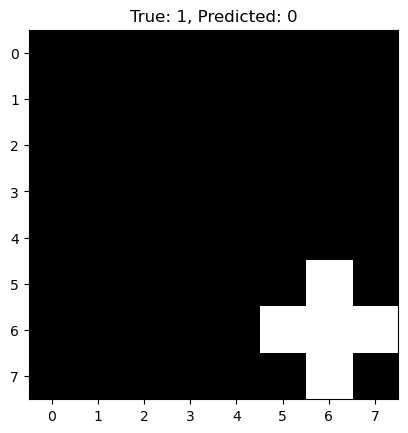

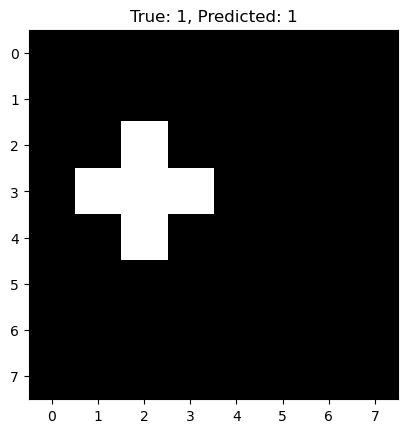

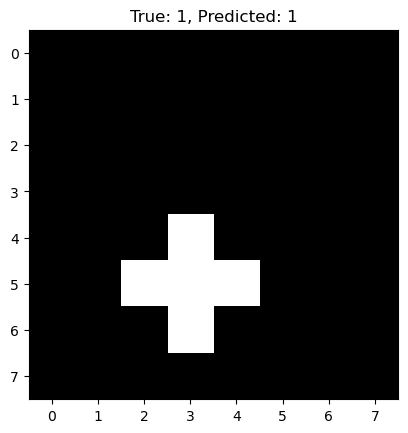

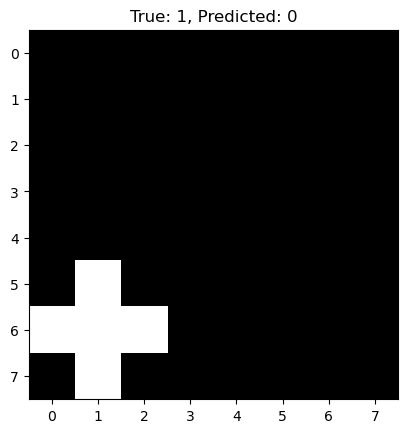

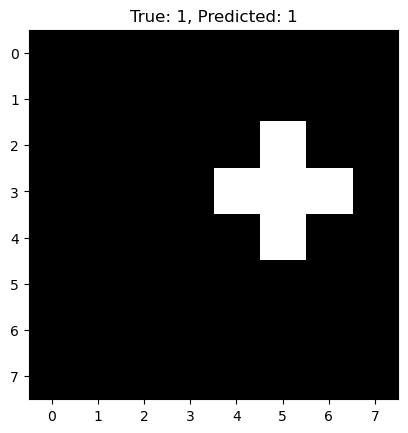

In [14]:
print("Visualizing predictions on the test set (unseen positions):")
visualize_predictions(model, test_dataset)


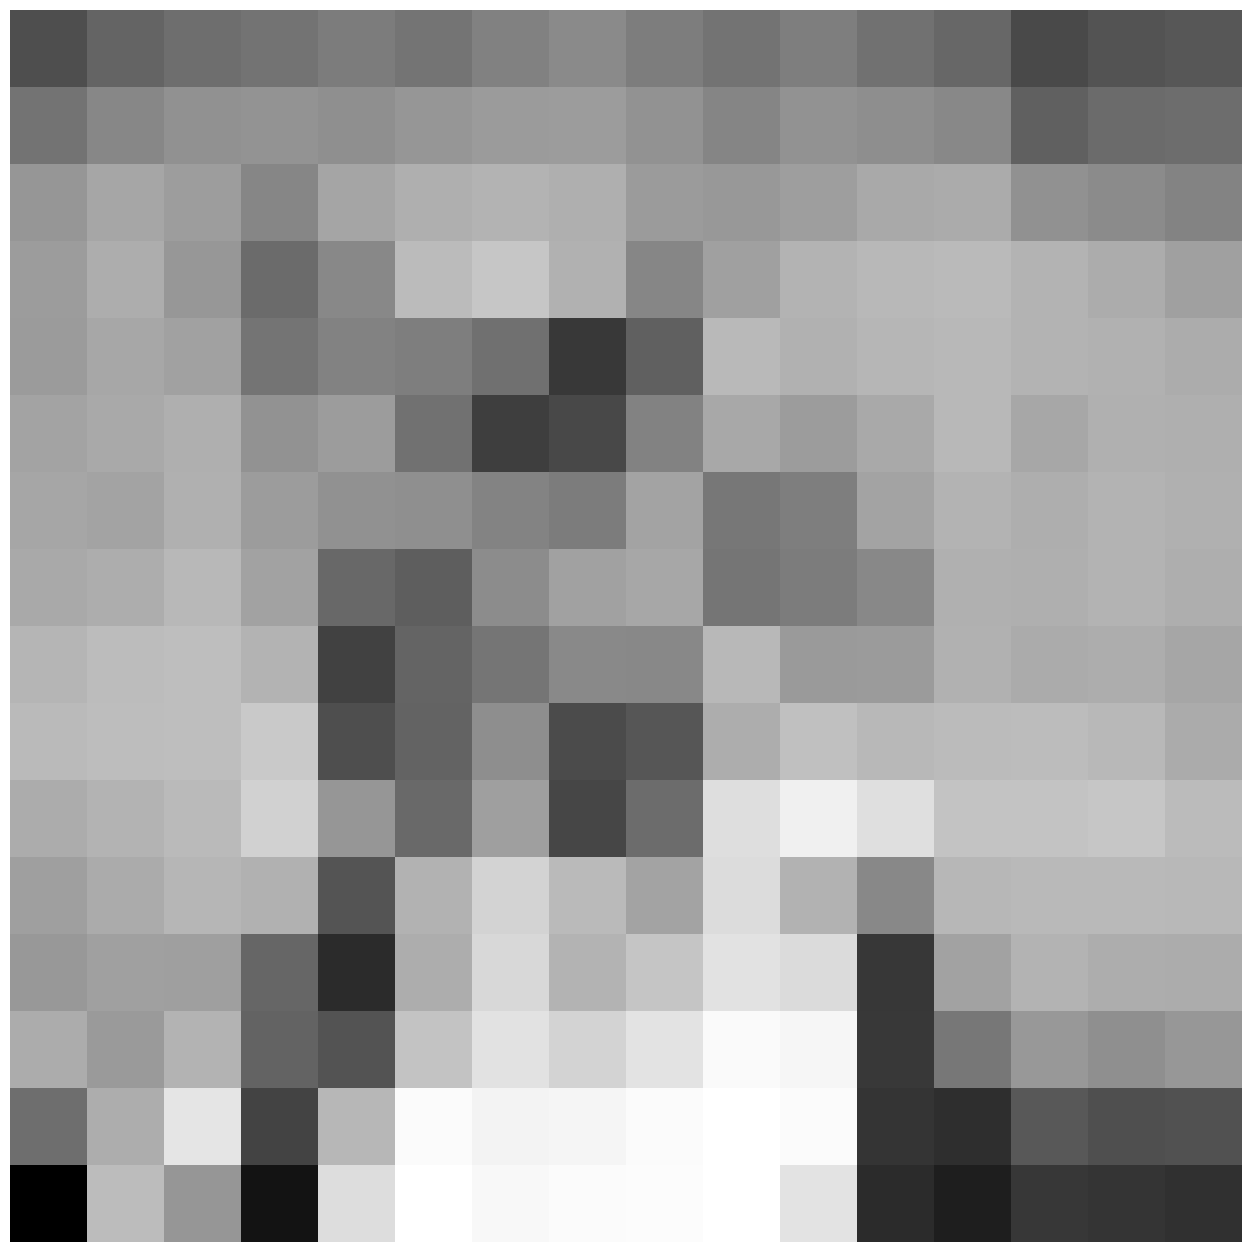

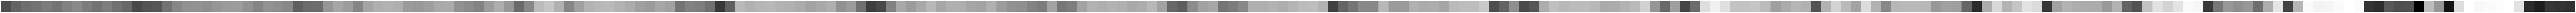

Flattened image vector:


In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the original image
original_image_path = "../assets/images/intro/cat.jpg"
original_image = Image.open(original_image_path).convert('L')

pixels_per_side = 16

# Resize the image to 8x8 pixels
low_res_image = original_image.resize((pixels_per_side, pixels_per_side), Image.Resampling.LANCZOS)

# Display the low-resolution image
fig, ax = plt.subplots(figsize=(pixels_per_side , pixels_per_side ))
ax.imshow(low_res_image, cmap="gray")
plt.axis("off")
plt.show()

# Flatten the image and display it as a vector
image_array = np.array(low_res_image)
flattened_image = image_array.flatten().reshape(1, pixels_per_side   * pixels_per_side, 1)

fig, ax = plt.subplots(figsize=(pixels_per_side * pixels_per_side, 1))
ax.imshow(flattened_image, cmap="gray")
plt.axis("off")
plt.show()

print("Flattened image vector:")



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 7116092.11it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 273737.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2474760.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1452575.58it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



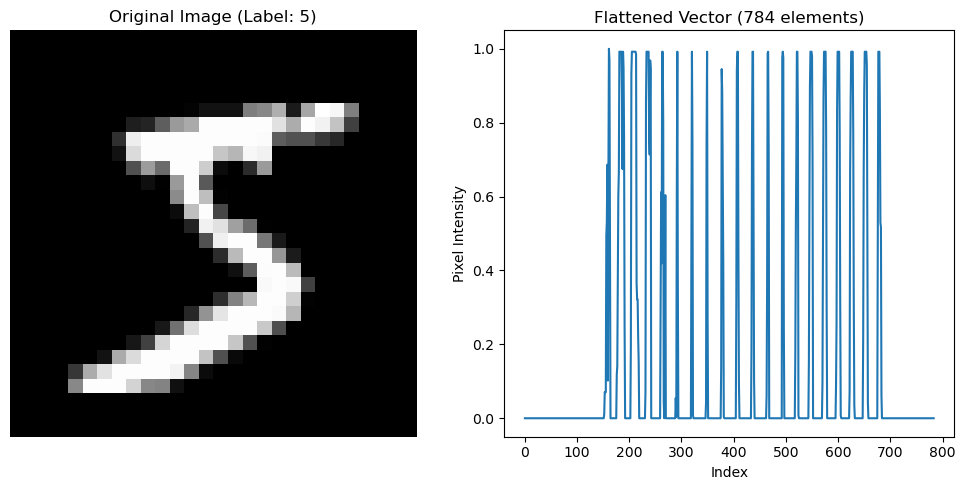

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Get a sample image and its label
sample_image, sample_label = mnist_train[0]

# Flatten the image from 28x28 to a vector of 784 elements
flattened_image = sample_image.view(-1)

# Display the original image and the flattened vector
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
ax[0].imshow(sample_image.squeeze(), cmap='gray')
ax[0].set_title(f"Original Image (Label: {sample_label})")
ax[0].axis('off')

# Plot the flattened vector
ax[1].plot(flattened_image.numpy())
ax[1].set_title("Flattened Vector (784 elements)")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Pixel Intensity")

plt.tight_layout()
plt.show()


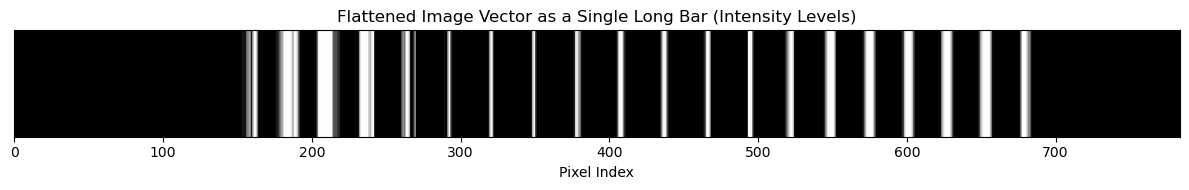

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Get a sample image and its label
sample_image, sample_label = mnist_train[0]

# Flatten the image from 28x28 to a vector of 784 elements
flattened_image = sample_image.view(-1)

# Plotting the flattened image as a sequence of boxes with varying intensity
fig, ax = plt.subplots(figsize=(12, 2))

# Reshape the flattened image for visualization as a long bar of varying intensity
ax.imshow(flattened_image.unsqueeze(0), cmap='gray', aspect='auto')

# Set labels and formatting
ax.set_title("Flattened Image Vector as a Single Long Bar (Intensity Levels)")
ax.set_xlabel("Pixel Index")
ax.set_yticks([])  # Remove y-axis ticks as they are irrelevant

plt.tight_layout()
plt.show()
